In [1]:
#Import Libraries 
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torch.optim as optim
from tqdm import tqdm
from torch.utils.data import DataLoader

import time
import os
import pandas as pd
from PIL import Image
import torchvision

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse

#for image processing and IOU 
import cv2
from shapely.geometry import Polygon
from shapely.ops import unary_union

import random


## Project Outline
- Helper functions: the first few sections of the code is for herlper functions: to test the data augmentation, or IOU, or mAP functions there is a code section below each. The helper functions are  
  - Data Augmentation: if you want to change augment a whole image and label folder uncomment the section below the data augmentation function and change the image and label folder
  - EllipsNet Network: uses ResNet 18 as backbone
  - Intersection over union
  - Nonmax suppresion
  - Mean Average Precision
  - Loss Function
  - Getting boxes: from relative to cell to relative to images
  - To Load the augmented file
  
## How to train and test
- To train change the image and label path file and also the csv file location that includes the image_name,label_name (both of the train and test dataset)
- From the quantitative result onwards, the ten_examples is from a csv file that includes the image,label names like for training also including the images and label directory being specified. Also the visulization is from local file. Hence, if needed to test the quantitaive and visulization result, change the directories accordingly. 
- If you don't want to train model, the weights are uploaded [here](https://drive.google.com/drive/folders/11TyjbFsJfzWGlGepfZAoL-cs0-jvJCfd) , hence load the weight and test with own dataset. The code to do this is found in the Plot train and test mAP section commented. Change the name of the saved model

## Data Augmentation and Generation new ground truth
- Step 1: Read the initial image and label names from csv file and open the image and get the x,y,w,h of the boxes
- Step 2: Augment the image
  - get random angle from 0 to 45
  - resize image to 448,448
  - rotate image using cv2.getRotationMatrix2D and cv2.warpAffine
- Step 3: Augment the label
    - since x,y (center of ellipse) change compared to initial center of rectangle when rotated use custom function to change 
    - use the new [x,y,w,h,angle] as label and save images and labels to new directory

In [2]:
import torchvision.transforms.functional as TF
import random

#function to change the x,y center of ellipse depending on chosen angle of rotation of image 
def convert_center(x,y,angle):
    # Define the center of rotation of image 
    center = (0.5, 0.5)

    # Create the rotation and translation matrix using OpenCV
    rotation_matrix = cv2.getRotationMatrix2D(center, angle, 1)
    original_point = np.array([[x], [y], [1]])

    # Convert the 2x3 rotation matrix to 3x3 to handle the affine transformation
    affine_matrix = np.vstack([rotation_matrix, [0, 0, 1]])
    rotated_point = np.dot(affine_matrix, original_point)

    # Extract and return the new x, y center of ellipse coordinates 
    new_x, new_y = rotated_point[0, 0], rotated_point[1, 0]
    return (new_x, new_y)

#function to get the bounding boxes from the labels txt files
def read_label_file(label_path):
    boxes = []
    with open(label_path, 'r') as f:
        for label in f.readlines():
            class_label, x, y, width, height = [
                float(x) if float(x) != int(float(x)) else int(x)
                for x in label.replace("\n", "").split()
            ]
            boxes.append([class_label, x, y, width, height])
    return boxes


#function to augment image (takes image input and bboxes as list of list)
def augment_image(image,bboxes):
    #resize and rotate image 
    image = cv2.resize(image, (448, 448))
    height, width = image.shape[:2]

    angle = random.uniform(0, 45)
    RM = cv2.getRotationMatrix2D((width/2, height/2), angle, 1.0)
    rotated_image = cv2.warpAffine(image, RM, (width, height))
    
    new_boxes = []
    
    for box in bboxes:
        #extract the label info and change the center x,y based on the angle
        class_label, x, y, width, height = box
        x_new, y_new = convert_center(x, y, angle)

        #add the new label if the new ellipse center is between 0 and 1 
        if 0 <= x_new < 1 and 0 <= y_new < 1:
            new_boxes.append([int(class_label), x_new, y_new, width, height, angle])
    
    return(rotated_image,new_boxes)


def augment_all_images(image_dir, label_dir, csv_file, output_img_dir, output_label_dir):
    
    #get the name of image and label files from the csv file and iterate trhough them
    annotations = pd.read_csv(csv_file, header=None, names=['image', 'label'])
    
    for index, row in annotations.iterrows():
        image_name = row['image']
        label_name = row['label']

        img_path = os.path.join(image_dir, image_name)
        label_path = os.path.join(label_dir, label_name)
        
        if not os.path.exists(label_path):
            print(f"Label file {label_path} not found.")
            continue

        image = cv2.imread(img_path)
        
        if image is None:
            print(f"Image file {img_path} not found.")
            continue
    
        #read the box labels for an image and get roated image and new bboxes
        boxes = read_label_file(label_path)
        rotated_image, new_boxes = augment_image(image,boxes)

        
        #save the rotated image and labels in the new directory
        os.makedirs(output_img_dir, exist_ok=True)
        output_img_path = os.path.join(output_img_dir, image_name)
        cv2.imwrite(output_img_path, rotated_image)

        os.makedirs(output_label_dir, exist_ok=True)
        output_label_path = os.path.join(output_label_dir, label_name)
        with open(output_label_path, 'w') as f:
            for box in new_boxes:
                f.write(" ".join(map(str, box)) + "\n")

In [3]:
# #convert the image and dataset labels to rotated image and respective labels
# #original and new image directories
# image_dir = 'Downloads/Lab4Data/images'
# label_dir = 'Downloads/Lab4Data/labels'
# ellipse_img_dir = 'Downloads/Lab4Data/ellipseimages'
# ellipse_label_dir = 'Downloads/Lab4Data/ellipselabels'

# #csv files containing image file name and label file names to augment 
# train_csv = 'Downloads/Lab4Data/train.csv'
# test_csv = 'Downloads/Lab4Data/test.csv'

# #augment both train and test data
# augment_all_images(image_dir, label_dir, train_csv, ellipse_img_dir, ellipse_label_dir)
# augment_all_images(image_dir, label_dir, test_csv, ellipse_img_dir, ellipse_label_dir)


### Functions to plot original image with rectangular bounding box and rotated image with elliptical bounding box

In [4]:
from matplotlib.patches import Rectangle
def plot_image_rect(image, boxes):
    
    # Convert input image to numpy array
    im = np.array(image)
    height, width, _ = im.shape

    # Display image 
    fig, ax = plt.subplots(1)
    ax.imshow(im)
    
    # Create a Rectangle patch
    for box in boxes:
        cls = int(box[0])
        prob = 1
        box = box[1:]
        assert len(box) == 4, "Got more values than in x, y, w, h, in a box!"

        # Calculate the top corner of bounding box
        upper_left_x = box[0] - box[2] / 2
        upper_left_y = box[1] - box[3] / 2

        # Create Rectangle patch
        rect = Rectangle(
            (upper_left_x * width, upper_left_y * height),
            box[2] * width,
            box[3] * height,
            linewidth=1,
            edgecolor="r",
            facecolor="none",
        )
        
        # Add the patch to the Axes
        ax.add_patch(rect)

        # Add class and probability text
        text = f"{img_labels[cls]}: {prob:.2f}"
        ax.text(
            upper_left_x * width,
            upper_left_y * height - 10,
            text,
            fontsize=10,
            color="r",
            verticalalignment="top",
            bbox={"facecolor": "white", "alpha": 0.7, "pad": 2},
        )

    return fig


#to create ellipse bboxes from label for plotting
def ellipse_to_polygon(x, y, width, height, rotation_angle, num_points=100):
   
    # Create an ellipse as a polygon approximation
    angles = np.linspace(0, 2 * np.pi, num_points)
    ellipse = np.column_stack((x + (width / 2) * np.cos(angles), y + (height / 2) * np.sin(angles)))
   
    #rotate the ellipse 
    R = cv2.getRotationMatrix2D((x, y), rotation_angle, 1)
    rotated = cv2.transform(np.array([ellipse]), R)[0]

    return Polygon(rotated)

#plot elliptical bounding boxes
def plot_image_rotated_ellipse(image, boxes):
    
    im = np.array(image)
    height, width, _ = im.shape

    # Create figure and display the image
    fig, ax = plt.subplots()
    ax.imshow(im)
    
    # Create an ellipse bounding box 
    for box in boxes:
        #get the class and probability information 
        cls = int(box[0])
        prob = 1
        box = box[1:]
        
        assert len(box) == 5, "Got more values than in x, y, w, h, θ in a box!"
        ellipse_box = ellipse_to_polygon(box[0],box[1], box[2], box[3], box[4], num_points=100)
        
        x1, y1 = ellipse_box.exterior.xy
        x1_scaled = [xi*width for xi in x1]
        y1_scaled = [yi*height for yi in y1]
        ax.plot(x1_scaled, y1_scaled, color='r', linewidth=1)
    
        text = f"{img_labels[cls]}: {prob:.2f}"
        ax.text(
            box[0]* width,
            box[1]* height + box[3]*height/2,
            text,
            fontsize=10,
            color="r",
            verticalalignment="top",
            bbox={"facecolor": "white", "alpha": 0.7, "pad": 2},
        )

    return fig

#function to get the ellipse bounding boxes from the labels           
def read_ellipse_label_file(label_path):
    boxes = []
    with open(label_path, 'r') as f:
        for label in f.readlines():
            class_label, x, y, width, height, angle = [
                float(x) if float(x) != int(float(x)) else int(x)
                for x in label.replace("\n", "").split()
            ]
            boxes.append([class_label, x, y, width, height, angle])
    return boxes

img_labels = {0:'aeroplane',
              1:'bicycle',
              2:'bird',
              3:'boat',
              4:'bottle',
              5:'bus',
              6:'car',
              7:'cat',
              8:'chair',
              9:'cow',
              10:'diningtable',
              11:'dog',
              12:'horse',
              13:'motorbike',
              14:'person',
              15:'pottedplant',
              16:'sheep',
              17:'sofa',
              18:'train',
              19:'tvmonitor'}

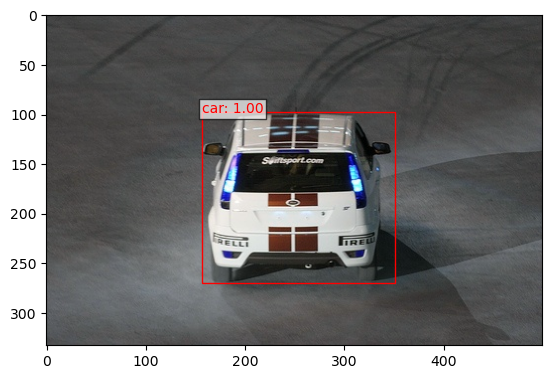

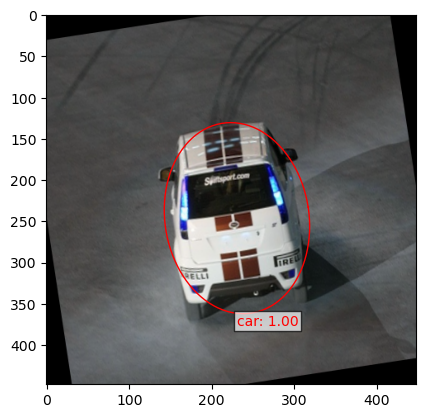

The bounding boxes for the rectangular:  [[6, 0.507, 0.551051051051051, 0.39, 0.5195195195195195]]
The bounding boxes for elliptical:  [[6, 0.5145780374299694, 0.5494235838250063, 0.39, 0.5195195195195195, 8.626437104955038]]


In [461]:
#TESTING Data augmentation
#The function augment_image(img,bboxes) can be used to check if working, the bboxes should be an input as list and
#if multiple as list of list

#uncomment to test

# rect_image = cv2.imread('Downloads/Lab4Data/images/000012.jpg')
# rect_labels = read_label_file('Downloads/Lab4Data/labels/000012.txt')

# #augment image and plot the images with their respective labels 
# ellipse_image, ellipse_labels = augment_image(rect_image,rect_labels)
# plt.show(plot_image_rect(rect_image, rect_labels))
# plt.show(plot_image_rotated_ellipse(ellipse_image, ellipse_labels))
# print('The bounding boxes for the rectangular: ',rect_labels)
# print('The bounding boxes for elliptical: ',ellipse_labels)

As we can see from the images above the image is reshaped to (448,448) and rotated by the angle specified in the label. The elliptical labels also match the expected rotation (the ellipse used is one inside the rectangle of the original bbox)

## EllipseNet Network
- The base structure used is from ResNet 18 with the last fully connected layer being removed and an addition convolution layer with a fully connected layer added to reshape the output to the expected 7x7x32. The input is images of 3 channel and shape of 448x448. The last layer outputs 7x7x32 where a gird size SxS of 7 is used. Each cell predicts 2 bounding box. There are 20 classes so each cell have C +(B*6) =  20 + (2*6) = 32 elements.

In [6]:
import torch
import torch.nn as nn
import torchvision.models as models
from torchvision.models import ResNet18_Weights

class EllipseNet(nn.Module):
    def __init__(self, input_channels=3, S=7, B=2, C=20):
        super(EllipseNet, self).__init__()
        # Load a pretrained ResNet-18
        base_model = models.resnet18(weights=ResNet18_Weights.DEFAULT)
        
        #If needed freeze layers but better result when not freezing 
        for param in base_model.parameters():
            param.requires_grad = True
        
        # Remove the fully connected layer (the last layers: avgpool and fc)
        self.features = nn.Sequential(*list(base_model.children())[:-2])
        
        # Additional conv layers to adapt from 512 output channels of ResNet-18
        self.additional_layers = nn.Sequential(
            nn.Conv2d(512, 1024, kernel_size=3, padding=1),  # Adjusted for 512 input channels
            nn.BatchNorm2d(1024),
            nn.LeakyReLU(0.1),
            nn.MaxPool2d(2, 2)
        )
        
        # Fully connected layers
        self.fully_connected = nn.Sequential(
            nn.Flatten(),
            nn.Linear(1024 * S * S, 4096),  #7x7
            nn.Dropout(0.5),
            nn.LeakyReLU(0.1),
            # An additional angle from the 5 other parameters (x,y,w,h,confidence) so 6
            nn.Linear(4096, S * S * (C + B * 6))  
        )
        
    def forward(self, x):
        x = self.features(x)
        x = self.additional_layers(x)
        return self.fully_connected(x)


In [7]:
#test model for 7x7 cell with 2 bounding box and 20 classes 
model = EllipseNet(S=7, B=2, C=20)
x = torch.randn((2,3,448,448))
print('For an input of 2 images with expected 3 channel and 448 shape the expected output is 2,7x7x32 = 2,1568')
print('Model shape: ', model(x).shape)


For an input of 2 images with expected 3 channel and 448 shape the expected output is 2,7x7x32 = 2,1568
Model shape:  torch.Size([2, 1568])


### Intersection over Union
- The inputs to the IOU function are two bboxes of shape [batchsize,7,7,5] where the 5 elements are x,y,w,h,angle and the outputs are [batchsize,7,7,1] where the iou of corresponding cells are found
- Shapely is used to find IOU and since shapely is CPU based the IOU computation is not integrated with pytorch

In [8]:
def intersection_over_union(boxes_preds, boxes_labels, num_points=100):
    
    # Convert all input tensors to numpy arrays for processing on cpu
    original_device = boxes_preds.device
    box1 = (boxes_preds.cpu()).detach().numpy()
    box2 = (boxes_labels.cpu()).detach().numpy()
    
    # Prepare the IoU results array
    batch_size, grid_size_1, grid_size_2, _ = box1.shape
    ious = np.empty((batch_size, grid_size_1, grid_size_2, 1))

    angles = np.linspace(0, 2 * np.pi, num_points)
    cos_angles = np.cos(angles)
    sin_angles = np.sin(angles)
    # Loop through each element in the batch and grid
    for i in range(batch_size):
        for j in range(grid_size_1):
            for k in range(grid_size_2):
                
                # Extract ellipse parameters
                x1, y1, w1, h1, orient1 = box1[i, j, k]
                x2, y2, w2, h2, orient2 = box2[i, j, k]
                
                # Generate ellipse coordinates
               
                ellipse1 = np.column_stack((x1 + (w1 / 2) * cos_angles, y1 + (h1 / 2) * sin_angles))
                ellipse2 = np.column_stack((x2 + (w2 / 2) * cos_angles, y2 + (h2 / 2) * sin_angles))

                # Get rotation matrices
                R1 = cv2.getRotationMatrix2D((x1, y1), orient1, 1)
                R2 = cv2.getRotationMatrix2D((x2, y2), orient2, 1)

                # Apply rotations to the ellipse points
                rotated1 = cv2.transform(np.array([ellipse1]), R1)[0]
                rotated2 = cv2.transform(np.array([ellipse2]), R2)[0]

                # Create ellipse
                polygon1 = Polygon(rotated1)
                polygon2 = Polygon(rotated2)

                # Calculate area of intersection and union
                intersection = polygon1.intersection(polygon2).area
                union = polygon1.union(polygon2).area

                # Compute IoU
                ious[i, j, k, 0] = intersection / union if union != 0 else 0
   
    # Convert the numpy array back to a PyTorch tensor
    return torch.from_numpy(ious).to(original_device)

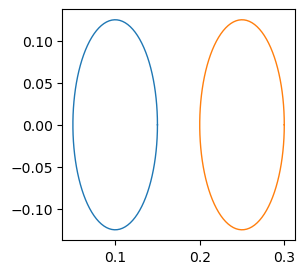

The IOU for the above boxes with no intersection is: 0.0


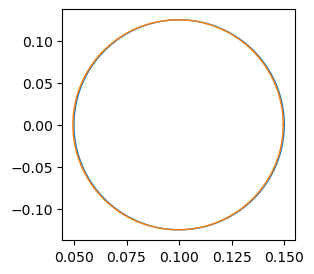

The IOU for the above boxes with almost total intersection is: 0.9873420118310479


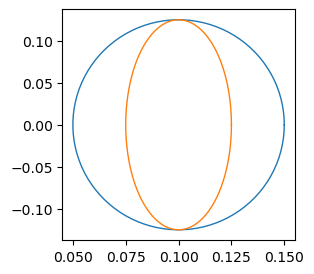

The IOU for the above boxes with one inside the other is: 0.49999945476016383


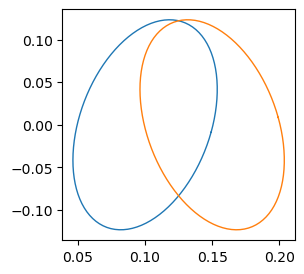

The IOU for the above boxes is: 0.2741550774633513


In [9]:
#plot ellipses for IOU testing
def plot_ellipses(box1,box2):
 
    fig, ax = plt.subplots(figsize=(3, 3))
    boxes = [box1.tolist()[0][0][0],box2.tolist()[0][0][0]]
    for box in boxes:
        assert len(box) == 5, "Got more values than in x, y, w, h, θ in a box!"
        ellipse_box = ellipse_to_polygon(box[0],box[1], box[2], box[3], box[4], num_points=100)
        
        x, y = ellipse_box.exterior.xy
        ax.plot(x,y, linewidth=1)
    
    return (fig)

### TEST IOU COMPUTATION #### 
box1 = torch.tensor([[[[0.1, 0, 0.1, 0.25, 0]]]])
box2 = torch.tensor([[[[0.25, 0, 0.1, 0.25, 0]]]])
plt.show(plot_ellipses(box1,box2))
print('The IOU for the above boxes with no intersection is:', intersection_over_union(box1,box2).item())

box1 = torch.tensor([[[[0.1, 0, 0.1, 0.25, 0]]]])
box2 = torch.tensor([[[[0.0995, 0., 0.1, 0.25, 0]]]])
plt.show(plot_ellipses(box1,box2))
print('The IOU for the above boxes with almost total intersection is:', intersection_over_union(box1,box2).item())

box1 = torch.tensor([[[[0.1, 0, 0.1, 0.25, 0]]]])
box2 = torch.tensor([[[[0.1, 0., 0.05, 0.25, 0]]]])
plt.show(plot_ellipses(box1,box2))
print('The IOU for the above boxes with one inside the other is:', intersection_over_union(box1,box2).item())


box1 = torch.tensor([[[[0.1, 0, 0.1, 0.25, 10]]]])
box2 = torch.tensor([[[[0.15, 0, 0.1, 0.25, -10]]]])
plt.show(plot_ellipses(box1,box2))
print('The IOU for the above boxes is:', intersection_over_union(box1,box2).item())

## Non-maximum suppression (NMS) 
- This function is to remove most of the predicted bounding boxes based on threshold of probability of object and IOU between the predicted bboxes. 

In [10]:
def non_max_suppression(bboxes, iou_threshold, prob_threshold):

    #bouding boxes input as lists with each bboxe [class, probability, x, y, a, b, θ]
    assert type(bboxes) == list

    # discard bounding boxes less than certain threshold 
    bboxes = [box for box in bboxes if box[1] > prob_threshold]

    # Sort bounding boxes in descending order using presence of object probability
    bboxes = sorted(bboxes, key=lambda x:x[1], reverse=True)

    # empty list for bouding box after suppresion
    bboxes_after_nms = []

    #loop through bounding boxes turn by turn choosing the highest prob one each time
    while bboxes:
        #select the highest prob object bounding box
        chosen_box = bboxes.pop(0) 
        
        # list comprehension saving bboxes of different class or same class having IoU less than threshold
        bboxes = [
            box
            for box in bboxes
            if box[0] != chosen_box[0] # if chosen bounding box not same class as current bbox keep
            or intersection_over_union( #find IOU using the defined function and if < threshold keep
                torch.tensor(chosen_box[2:]).unsqueeze(0).unsqueeze(0).unsqueeze(0),
                torch.tensor(box[2:]).unsqueeze(0).unsqueeze(0).unsqueeze(0),
            ) < iou_threshold 
        ]

        bboxes_after_nms.append(chosen_box)

    return bboxes_after_nms

### Mean Average Precision

In [410]:
from collections import Counter

#calculate average precision for one IOU threshold 
def average_precision(pred_boxes, true_boxes, iou_threshold=0.5, num_classes=20):
    #pred and true boxes = lists specified as [train/true_idx, class_prediction, prob_score, x, y, a, b, θ]

    # list to store avg_precision for each class
    average_precisions = []
    epsilon = 1e-6
    for c in range(num_classes):
        detections = []
        ground_truths = []

        # for current class c append pred_boxes and true_boxes of that class
        for detection in pred_boxes:
            if detection[1] == c:
                detections.append(detection)

        for true_box in true_boxes:
            if true_box[1] == c:
                ground_truths.append(true_box)

        #for each image find the num of bounding boxes as dictionary: index:value(num of bbox)
        amount_bboxes = Counter([gt[0] for gt in ground_truths])

        #convert the dictionary to tensor of zeros with length = value of dictionary 
        # eg: if 0:2, 1:3 ammount_bboxes = {0:torch.tensor[0,0], 1:torch.tensor[0,0,0]}
        # this is to keep track of ground truth (traget) bounding box covered 
        for key, val in amount_bboxes.items():
            amount_bboxes[key] = torch.zeros(val)

        # sort by probability (confidence) from highest to lowest and initialize TP and FP zeros 
        detections.sort(key=lambda x: x[2], reverse=True)
        TP = torch.zeros((len(detections)))
        FP = torch.zeros((len(detections)))
        total_true_bboxes = len(ground_truths)
        
        # skip class if no true boxes
        if total_true_bboxes == 0:
            continue

        #take a particular bounding box for a particular class (then loop through them)
        for detection_idx, detection in enumerate(detections):
            # take ground truth that have same index as training (same image)
            ground_truth_img = [
                bbox for bbox in ground_truths if bbox[0] == detection[0]
            ]

            num_gts = len(ground_truth_img)
            best_iou = 0
            
            #find box with highest IOU (go throug the ground truth bounding box of same image)
            for idx, gt in enumerate(ground_truth_img):
            
                iou = intersection_over_union(
                    torch.tensor(detection[3:]).unsqueeze(0).unsqueeze(0).unsqueeze(0),
                    torch.tensor(gt[3:]).unsqueeze(0).unsqueeze(0).unsqueeze(0)
                )

                if iou > best_iou:
                    best_iou = iou
                    best_gt_idx = idx

            #categorize as TP or FP
            
            if best_iou > iou_threshold:
                # check if this true bounding box have been checked before and if not update TP
                if amount_bboxes[detection[0]][best_gt_idx] == 0:
                    TP[detection_idx] = 1
                    amount_bboxes[detection[0]][best_gt_idx] = 1
                else:
                    FP[detection_idx] = 1
            else:
                FP[detection_idx] = 1

        #do cumulative sum of TP and FP
        TP_cumsum = torch.cumsum(TP, dim=0)
        FP_cumsum = torch.cumsum(FP, dim=0)
        recalls = TP_cumsum / (total_true_bboxes + epsilon)
        precisions = torch.divide(TP_cumsum, (TP_cumsum + FP_cumsum + epsilon))
        precisions = torch.cat((torch.tensor([1]), precisions))
        recalls = torch.cat((torch.tensor([0]), recalls))
        
        #compute area using trapezoid rule 
        average_precisions.append(torch.trapz(precisions, recalls))

    #return mAP for all classes of specific IOU
    return sum(average_precisions) / len(average_precisions)


#TO FIND MEAN Avg precision across different IOUS when chosen to do that 
def mean_average_precision(pred_boxes, true_boxes, Specific_IOU=True, num_classes=20):
    
    if(Specific_IOU):
        #use traditional IOU threshold of 0.5
        iou_threshold=0.5
        return(average_precision(pred_boxes, true_boxes, iou_threshold, num_classes))
    
    else: 
        #use IOU from 0.1 to 0.8 with step size of 0.05
        IOU_values = np.arange(0.1, 0.9, 0.05)
        mAPs = []
        
        for iou in IOU_values:
            mAPs.append(average_precision(pred_boxes, true_boxes, iou, num_classes))
            
        return (sum(mAPs) / len(mAPs))
        

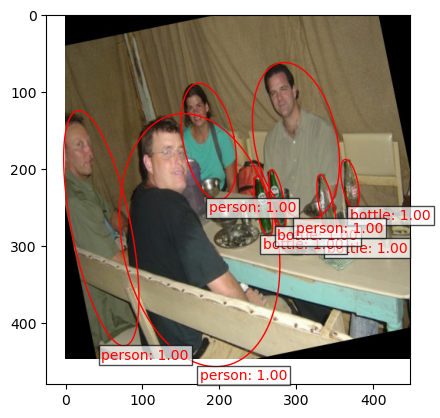

The Mean Average Precision for similar images (with itself) is as expected: 0.9999991059303284


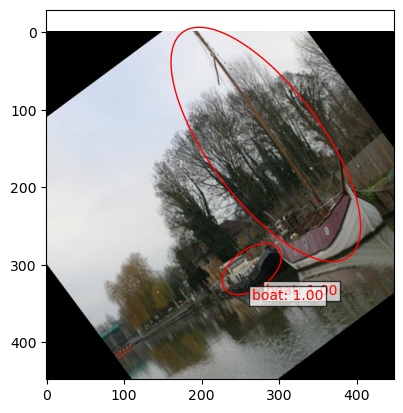

The Mean Average Precision for different images (the first and second): 0.0


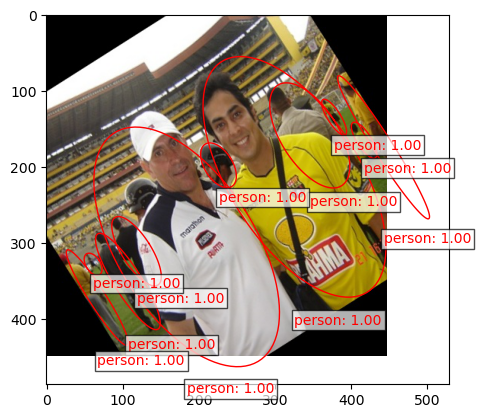

The Mean Average Precision for different images (the first and third): 0.09540713578462601
the mAP is not exactly zero when both images (first and third) have multiple people proving its correctness


In [411]:
###Testing mAP###
ellipse_image1 = Image.open('Downloads/Lab4Data/ellipseimages/000050.jpg')
ellipse_labels1 = read_ellipse_label_file('Downloads/Lab4Data/ellipselabels/000050.txt')
plt.show(plot_image_rotated_ellipse(ellipse_image1, ellipse_labels1))

#The ellipse label read is class,x,y,w,h,angle from data set but the mAP requires additional 
# train/test idx (to identify similar images) and probability of object after training but for testing the mAP
#an idx of 1 and probability of 1 can be inserted since these are true images
for box in ellipse_labels1:
    box.insert(0, 0) 
    box.insert(2, 1) 

similar_mAP = mean_average_precision(ellipse_labels1,ellipse_labels1,Specific_IOU=False)
print(f"The Mean Average Precision for similar images (with itself) is as expected: {similar_mAP}")

ellipse_image2 = Image.open('Downloads/Lab4Data/ellipseimages/000061.jpg')
ellipse_labels2 = read_ellipse_label_file('Downloads/Lab4Data/ellipselabels/000061.txt')
#plot before adding new elements
plt.show(plot_image_rotated_ellipse(ellipse_image2, ellipse_labels2))

for box in ellipse_labels2:
    box.insert(0, 0) 
    box.insert(2, 1) 
    
different_mAP = mean_average_precision(ellipse_labels1,ellipse_labels2,Specific_IOU=False)
print(f"The Mean Average Precision for different images (the first and second): {different_mAP}")


ellipse_image3 = Image.open('Downloads/Lab4Data/ellipseimages/000076.jpg')
ellipse_labels3 = read_ellipse_label_file('Downloads/Lab4Data/ellipselabels/000076.txt')
#plot before adding new elements
plt.show(plot_image_rotated_ellipse(ellipse_image3, ellipse_labels3))

for box in ellipse_labels3:
    box.insert(0, 0) 
    box.insert(2, 1) 
    
different_humans_mAP = mean_average_precision(ellipse_labels1,ellipse_labels3,Specific_IOU=False)
print(f"The Mean Average Precision for different images (the first and third): {different_humans_mAP}")
print('the mAP is not exactly zero when both images (first and third) have multiple people proving its correctness')

## EllipseNet Loss  Function
- The loss function is similar to that of YoloV1 The only added term is $
\lambda_{\text{coord}} \sum_{i=0}^{S^2} \sum_{j=0}^{B} 1^{\text{obj}}_{ij} \left( angle_i - \hat{angle}_i \right)^2
$ . The angle is divide by the range of the angle. For instance, if the angle is selected from 0 to 45 it is divided by 45. A lower lamda can also be used for this. The main purpose is to give it equal importance as the other ellipse coordinates (x,y,w,h) since each are between 0 and 1. 


In [13]:
class EllipseNetLoss(nn.Module):

    #cells/split size (S) = 7, bounding box (B) = 2, classes (C) = 20
    def __init__(self, S=7, B=2, C=20):
        super(EllipseNetLoss, self).__init__()
        self.mse = nn.MSELoss(reduction="sum")

        self.S = S
        self.B = B
        self.C = C
        self.lambda_noobj = 0.1 #reduced since result improved when reduced from the initial 0.5 
        self.lambda_coord = 5

    def forward(self, predictions, target):
        #reshape prediction to batch_size,7,7,32
        predictions = predictions.reshape(-1, self.S, self.S, self.C + self.B * 6)

        # Calculate IoU for each bounding box with the target
        #here take 21:26 (excludes the 26th) for prediction b1 and 27:32 for b2 and 21:26 for target since C = 20
        iou_b1 = intersection_over_union(predictions[..., self.C + 1:self.C + 6], target[..., self.C + 1:self.C + 6])
        iou_b2 = intersection_over_union(predictions[..., self.C + 7:self.C + 12], target[..., self.C + 1:self.C + 6])
        
        #concatenate the two IOUs and store the maximum value and the corresponding box (0 or 1)
        iou_concatenated = torch.cat([iou_b1.unsqueeze(0), iou_b2.unsqueeze(0)], dim=0)
        iou_maxes, bestbox = torch.max(iou_concatenated, dim=0)
        
        #get the confidence of target and unsqueeze in 3rd dimension
        exist_box = target[..., self.C].unsqueeze(3)  

        ### BOX COORDINATES LOSS ###
        
        # get the box dimensions of cell prediction boxes which have corresponding object in the target
        box_predictions = exist_box * (
            (
                bestbox * predictions[..., self.C + 7:self.C + 12] #if the second box (1) has the highest IOU
                + (1 - bestbox) * predictions[..., self.C + 1:self.C + 6] #if the other one 
            )
        )

        #get the target box dimensions of cells with target object inside them
        box_targets = exist_box * target[..., self.C + 1:self.C + 6]

        # take sqrt of the width and height, use abs since some predictions may be negative but not target
        box_predictions[..., 2:4] = torch.sign(box_predictions[..., 2:4]) * torch.sqrt(
            torch.abs(box_predictions[..., 2:4] + 1e-5)
        )
        
        box_targets[..., 2:4] = torch.sqrt(box_targets[..., 2:4])
        
        #normalize angle/orientation 
        box_predictions[..., 4:5] = box_predictions[..., 4:5]/45
        box_targets[..., 4:5] = box_targets[..., 4:5]/45
        
        #flatten and compute the MSE (Box loss)
        box_loss = self.mse(
            torch.flatten(box_predictions, end_dim=-2),
            torch.flatten(box_targets, end_dim=-2),
        )
        
        ### OBJECT LOSS ###

        # pred_box = confidence score for the box of the two predicted with highest IOU with the target
        pred_box = ( 
            bestbox * predictions[..., self.C + 6:self.C + 7] #if the second bounding box (1) has highest IOU
            + (1 - bestbox) * predictions[..., self.C:self.C + 1] #if the first 
        )

        #flatten and compute the MSE (if object exist in target)
        object_loss = self.mse(
            torch.flatten(exist_box * pred_box),
            torch.flatten(exist_box * target[..., self.C:self.C + 1]),
        )
        
        
        ### NO OBJECT LOSS ###

        no_object_loss = self.mse(
            torch.flatten((1 - exist_box) * predictions[..., self.C:self.C + 1], start_dim=1),
            torch.flatten((1 - exist_box) * target[..., self.C:self.C + 1], start_dim=1),
        )

        #for second bounding box 
        no_object_loss += self.mse(
            torch.flatten((1 - exist_box) * predictions[..., self.C + 6:self.C + 7], start_dim=1),
            torch.flatten((1 - exist_box) * target[..., self.C:self.C + 1], start_dim=1)
        )

        ### CLASS LOSS (compute class loss for all classes here 20) ###
        
        #in flatten use end_dim = -2 for N,S,S,C to NxSxS,C where C = 20
        class_loss = self.mse(
            torch.flatten(exist_box * predictions[..., :self.C], end_dim=-2,),
            torch.flatten(exist_box * target[..., :self.C], end_dim=-2,),
        )
       
        #compute total loss considering the lambda values
        loss = (
            (self.lambda_coord * box_loss) + object_loss + (self.lambda_noobj * no_object_loss) + class_loss 
        )
    
        return loss

## Get all true and prediction bounding boxes relative to entire image
- After loading the data, the coordinates of the bboxes are converted with respect to the cells to find the cell responsible for predicting the object. In the end the coordinates are converted back to the image ratio before plotting, doing mAp...  using these functions

In [14]:
def convert_cellboxes(predictions, S=7):

    #convert bboxes from relative to a cell to relative to entire image
    # Reshape the prediction and select the best bounding box
    predictions = predictions.to("cpu")
    batch_size = predictions.shape[0]
    predictions = predictions.reshape(batch_size, 7, 7, 32)
    bboxes1 = predictions[..., 21:26]
    bboxes2 = predictions[..., 27:32]
    scores = torch.cat(
        (predictions[..., 20].unsqueeze(0), predictions[..., 26].unsqueeze(0)), dim=0
    )
    best_box = scores.argmax(0).unsqueeze(-1)
    best_boxes = bboxes1 * (1 - best_box) + best_box * bboxes2

    # Converting the coordinates with respect to image ratio
    cell_indices = torch.arange(7).repeat(batch_size, 7, 1).unsqueeze(-1) # (batch_size, 7, 7, 1)
    #scale from cell space (0 to 1) to image space (0 to 1)
    x = 1 / S * (best_boxes[..., :1] + cell_indices)
    y = 1 / S * (best_boxes[..., 1:2] + cell_indices.permute(0, 2, 1, 3))
    #just scaling of width and height and keep orientation
    w_y = 1 / S * best_boxes[..., 2:4]

    converted_bboxes = torch.cat((x, y, w_y, best_boxes[..., 4:5]), dim=-1) # batch_size, 7, 7, 5 
    #select the predicted class with the highest probability batch_size, 7, 7, 1
    predicted_class = predictions[..., :20].argmax(-1).unsqueeze(-1) 
    best_confidence = torch.max(predictions[..., 20], predictions[..., 26]).unsqueeze(-1) # batch_size, 7, 7, 1
    converted_preds = torch.cat(
        (predicted_class, best_confidence, converted_bboxes), dim=-1
    )

    # batch_size, 7, 7, 7  
    return converted_preds 

def cellboxes_to_boxes(out, S=7):
    converted_pred = convert_cellboxes(out).reshape(out.shape[0], S * S, -1) #reshape batch_size,7x7,7
    converted_pred[..., 0] = converted_pred[..., 0].long()
    all_bboxes = []
            
    # For each image in the batch extract all 7 values of each cell and append to bounding box (list)
    #, and append each image's bounding boxes in the batch to all_bboxes 
    for ex_idx in range(out.shape[0]):
        bboxes = []
        
        for bbox_idx in range(S * S):
            bboxes.append([x.item() for x in converted_pred[ex_idx, bbox_idx, :]])
        all_bboxes.append(bboxes)

    return all_bboxes

def get_bboxes(
    loader,
    model,
    iou_threshold,
    threshold,
    device="cuda",
):
    #initialize list to store all pred and true boxes
    all_pred_boxes = []
    all_true_boxes = []

    # ensure that the model is in eval before getting bboxes
    model.eval()
    train_idx = 0

    for batch_idx, (x, labels) in enumerate(loader):
        x = x.to(device)
        labels = labels.to(device)

        #disable gradient calculation and find models output for current batch
        with torch.no_grad():
            predictions = model(x)

        batch_size = x.shape[0]
        #convert from labels and prediction cell format to box format 
        true_bboxes = cellboxes_to_boxes(labels)
        bboxes = cellboxes_to_boxes(predictions)

        # For each image in each batch do NMS
        for idx in range(batch_size):
            nms_boxes = non_max_suppression( 
                bboxes[idx],
                iou_threshold=iou_threshold,
                prob_threshold=threshold,
            )

            for nms_box in nms_boxes:
                all_pred_boxes.append([train_idx] + nms_box)

            for box in true_bboxes[idx]:
                if box[1] > threshold:
                    all_true_boxes.append([train_idx] + box)

            train_idx += 1

    #set model back to training and return all boxes
    model.train()
    return all_pred_boxes, all_true_boxes

## Load the augmented image and ellipse labels

In [15]:
import torchvision.transforms.functional as TF

class ELLIPSEDataset(torch.utils.data.Dataset):
    
    def __init__(self, csv_file, img_dir, label_dir, S=7, B=2, C=20):
        
        #csv_file contain name of image and label text files 
        self.annotations = pd.read_csv(csv_file)
        self.img_dir = img_dir
        self.label_dir = label_dir
        self.S = S
        self.B = B
        self.C = C

    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, index):
        #construct labels path by joining the lable directory and the label text files 
        label_path = os.path.join(self.label_dir, self.annotations.iloc[index, 1])
        boxes = []
        
        with open(label_path) as f:
            for label in f.readlines():
                class_label, x, y, width, height,orient = [
                    float(x) if float(x) != int(float(x)) else int(x)
                    for x in label.replace("\n","").split()
                ]
                # Append bounding box for the label 
                boxes.append([class_label, x, y, width, height,orient])
                
       
        img_path = os.path.join(self.img_dir, self.annotations.iloc[index, 0])
        image = Image.open(img_path).convert("RGB")
        
        #preprocess as suggested by pytorch pretrained RESNET website
        transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])
        tensor_image = transform(image)
            
        boxes = torch.tensor(boxes)

        #to reformat the labels to a SxSx32 matrix
        label_matrix = torch.zeros((self.S, self.S, self.C + 6*self.B))
        
        for box in boxes:
            class_label, x, y, width, height, orient = box.tolist()
            class_label = int(class_label)   

            # to get the cell row and column which the midpoint of the target object (ellipse) should be assigned to
            i , j = int(self.S * y), int(self.S * x)

            # find x,y relative to the cell (rescale to 0 to 1)
            x_cell, y_cell = self.S * x - j, self.S * y - i
            width_cell, height_cell = (
              width * self.S,
              height * self.S
            )

            #if the 20th element (identify an object = 0) reset to 1 (one object restriction per cell)
            if label_matrix[i,j,self.C] == 0: 
                label_matrix[i,j,self.C] = 1

                box_coordinates = torch.tensor(
                    [x_cell, y_cell, width_cell, height_cell, orient]
                )
                #fill the box coordiantes and specify which class the object belongs to 
                label_matrix[i,j,21:26] = box_coordinates
                label_matrix[i,j,class_label] = 1

        return tensor_image, label_matrix

### Load the train and test ellipse dataset

In [16]:
seed = 123
torch.manual_seed(seed)

#Hyperparameters
LEARNING_RATE = 1e-5
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
BATCH_SIZE = 16
EPOCHS = 100
IMG_DIR = 'Downloads/Lab4Data/ellipseimages'
LABEL_DIR = 'Downloads/Lab4Data/ellipselabels'

#create dataloader for train and test datasets
train_dataset = ELLIPSEDataset(
    "Downloads/Lab4Data/train.csv",
    img_dir = IMG_DIR,
    label_dir = LABEL_DIR,
)

test_dataset = ELLIPSEDataset(
    "Downloads/Lab4Data/test.csv",
    img_dir = IMG_DIR,
    label_dir= LABEL_DIR,
)

train_loader = DataLoader(
    dataset=train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True
)

test_loader = DataLoader(
    dataset=test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False
)

## Training + mAP and Loss Curve Calculation

In [17]:
# Instantiate model
model = EllipseNet(S=7, B=2, C=20).to(DEVICE)

# Define optimizer and loss fun
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
loss_fn = EllipseNetLoss()

# Save train and test history
history_tl = []  # For epoch vs. loss
history_ta = [] # For epoch vs. mAP
history_testloss = []
history_testmAp = []



for epoch in tqdm(range(EPOCHS), desc='EPOCHS'):
    
    # Set the model to training mode and save start time of the epoch
    model.train()  
    start_time = time.time() 

    mean_loss = []
    mean_testloss = []

    # Iterate over the training data in batches
    for inputs, labels in train_loader:
        
        # Move the inputs and labels to the selected device
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)

        # Forward pass
        outputs = model(inputs)
        torch.cuda.empty_cache() # Limit GPU memory growth
        
        # Calculate the loss
        loss = loss_fn(outputs, labels)
        mean_loss.append(loss.item())

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        torch.cuda.empty_cache() # Limit GPU memory growth

    end_time = time.time()  # End time of the epoch
    epoch_duration = end_time - start_time  # Duration of the epoch

    
    # Use the trained model to predict label
    pred_boxes, target_boxes = get_bboxes(
        train_loader, model, iou_threshold=0.5, threshold=0.4
    )
    
    # Calculate the mean average precision after every epoch/training
    mean_avg_prec = mean_average_precision(
        pred_boxes, target_boxes, Specific_IOU=True
    )
    
    history_tl.append(sum(mean_loss)/len(mean_loss))
    history_ta.append(mean_avg_prec)
    
    model.eval()
    
    with torch.no_grad():
        
        for inputs_test,test_label in test_loader:

            inputs_test = inputs_test.to(DEVICE)
            test_label = test_label.to(DEVICE)

            outputs_test = model(inputs_test)
            torch.cuda.empty_cache() # Limit GPU memory growth

            # Calculate the test loss
            loss_test = loss_fn(outputs_test, test_label)
            mean_testloss.append(loss_test.item())
        
        # Use the trained model to predict label  
        test_pred_boxes, test_target_boxes = get_bboxes(
            test_loader, model, iou_threshold=0.5, threshold=0.4
        )

        # Calculate the mean average precision after every epoch/training
        test_mean_avg_prec = mean_average_precision(
            test_pred_boxes, test_target_boxes, Specific_IOU=True
        )
    
        history_testloss.append(sum(mean_testloss)/len(mean_testloss))
        history_testmAp.append(test_mean_avg_prec)
        
        
    # Print the epoch duration
    tqdm.write(f"Epoch {epoch+1} Training completed in {epoch_duration:.2f} seconds")

    # Print the loss and accuracy for training and validation data
    print(f"Epoch [{epoch+1}/{EPOCHS}], "
          f" Train Loss: {sum(mean_loss)/len(mean_loss):.4f}, mAP: {mean_avg_prec:.8f} \n"
          f"Test Loss: {sum(mean_testloss)/len(mean_testloss):.4f}, mAP: {test_mean_avg_prec:.8f}")

    # Save the model after every 10 epochs
    if (epoch+1) % 5 == 0:
      torch.save(model.state_dict(), f'model_epoch{epoch+1}.pth')

    

EPOCHS:   1%|          | 1/100 [19:03<31:26:09, 1143.13s/it]

Epoch 1 Training completed in 502.58 seconds
Epoch [1/100],  Train Loss: 280.2459, mAP: 0.11470391 
Test Loss: 168.3390, mAP: 0.09959656


EPOCHS:   2%|▏         | 2/100 [36:13<29:18:33, 1076.67s/it]

Epoch 2 Training completed in 496.91 seconds
Epoch [2/100],  Train Loss: 185.8893, mAP: 0.18073438 
Test Loss: 138.8325, mAP: 0.16372344


EPOCHS:   3%|▎         | 3/100 [52:37<27:52:26, 1034.50s/it]

Epoch 3 Training completed in 499.58 seconds
Epoch [3/100],  Train Loss: 157.3356, mAP: 0.24476603 
Test Loss: 126.7912, mAP: 0.20532694


EPOCHS:   4%|▍         | 4/100 [1:09:27<27:19:54, 1024.94s/it]

Epoch 4 Training completed in 499.84 seconds
Epoch [4/100],  Train Loss: 139.1692, mAP: 0.29006863 
Test Loss: 117.9283, mAP: 0.22722268


EPOCHS:   4%|▍         | 4/100 [1:25:55<27:19:54, 1024.94s/it]

Epoch 5 Training completed in 500.08 seconds
Epoch [5/100],  Train Loss: 125.0034, mAP: 0.32264289 
Test Loss: 111.1083, mAP: 0.22769734


EPOCHS:   6%|▌         | 6/100 [1:43:06<26:34:42, 1017.90s/it]

Epoch 6 Training completed in 499.76 seconds
Epoch [6/100],  Train Loss: 113.2117, mAP: 0.36495453 
Test Loss: 105.1736, mAP: 0.23603992


EPOCHS:   7%|▋         | 7/100 [1:59:29<25:59:53, 1006.38s/it]

Epoch 7 Training completed in 501.29 seconds
Epoch [7/100],  Train Loss: 103.4363, mAP: 0.40927711 
Test Loss: 102.0596, mAP: 0.24868020


EPOCHS:   8%|▊         | 8/100 [2:16:28<25:49:23, 1010.47s/it]

Epoch 8 Training completed in 501.44 seconds
Epoch [8/100],  Train Loss: 95.1909, mAP: 0.45538458 
Test Loss: 98.6907, mAP: 0.25805834


EPOCHS:   9%|▉         | 9/100 [2:33:14<25:30:30, 1009.12s/it]

Epoch 9 Training completed in 501.62 seconds
Epoch [9/100],  Train Loss: 88.1784, mAP: 0.49417394 
Test Loss: 95.4967, mAP: 0.26206899


EPOCHS:   9%|▉         | 9/100 [2:49:56<25:30:30, 1009.12s/it]

Epoch 10 Training completed in 502.65 seconds
Epoch [10/100],  Train Loss: 82.5860, mAP: 0.52065289 
Test Loss: 93.9107, mAP: 0.26440626


EPOCHS:  11%|█         | 11/100 [3:06:17<24:41:54, 999.04s/it] 

Epoch 11 Training completed in 505.23 seconds
Epoch [11/100],  Train Loss: 76.9352, mAP: 0.54058850 
Test Loss: 91.0021, mAP: 0.25885862


EPOCHS:  12%|█▏        | 12/100 [3:22:48<24:21:16, 996.32s/it]

Epoch 12 Training completed in 502.58 seconds
Epoch [12/100],  Train Loss: 72.9332, mAP: 0.55924004 
Test Loss: 89.0753, mAP: 0.24996133


EPOCHS:  13%|█▎        | 13/100 [3:38:45<23:47:33, 984.53s/it]

Epoch 13 Training completed in 502.36 seconds
Epoch [13/100],  Train Loss: 68.9334, mAP: 0.59862697 
Test Loss: 88.4210, mAP: 0.27491805


EPOCHS:  14%|█▍        | 14/100 [3:54:43<23:19:37, 976.49s/it]

Epoch 14 Training completed in 502.65 seconds
Epoch [14/100],  Train Loss: 65.6812, mAP: 0.61379296 
Test Loss: 87.6353, mAP: 0.26761541


EPOCHS:  14%|█▍        | 14/100 [4:10:58<23:19:37, 976.49s/it]

Epoch 15 Training completed in 502.94 seconds
Epoch [15/100],  Train Loss: 62.4002, mAP: 0.63214141 
Test Loss: 85.3781, mAP: 0.26963609


EPOCHS:  16%|█▌        | 16/100 [4:27:05<22:42:27, 973.19s/it]

Epoch 16 Training completed in 504.08 seconds
Epoch [16/100],  Train Loss: 59.6284, mAP: 0.65231788 
Test Loss: 84.7232, mAP: 0.26949364


EPOCHS:  17%|█▋        | 17/100 [4:42:56<22:16:55, 966.46s/it]

Epoch 17 Training completed in 501.18 seconds
Epoch [17/100],  Train Loss: 58.0177, mAP: 0.66371697 
Test Loss: 84.8862, mAP: 0.26524049


EPOCHS:  18%|█▊        | 18/100 [4:58:48<21:54:51, 962.09s/it]

Epoch 18 Training completed in 500.77 seconds
Epoch [18/100],  Train Loss: 54.7086, mAP: 0.69075668 
Test Loss: 83.8905, mAP: 0.27818128


EPOCHS:  19%|█▉        | 19/100 [5:14:34<21:32:38, 957.51s/it]

Epoch 19 Training completed in 501.45 seconds
Epoch [19/100],  Train Loss: 52.6809, mAP: 0.68947643 
Test Loss: 82.5089, mAP: 0.27461264


EPOCHS:  19%|█▉        | 19/100 [5:30:06<21:32:38, 957.51s/it]

Epoch 20 Training completed in 503.20 seconds
Epoch [20/100],  Train Loss: 51.2732, mAP: 0.71082729 
Test Loss: 82.9573, mAP: 0.28133726


EPOCHS:  21%|██        | 21/100 [5:45:50<20:48:07, 947.94s/it]

Epoch 21 Training completed in 508.61 seconds
Epoch [21/100],  Train Loss: 49.8119, mAP: 0.70658010 
Test Loss: 82.4167, mAP: 0.27199441


EPOCHS:  22%|██▏       | 22/100 [6:01:40<20:33:12, 948.63s/it]

Epoch 22 Training completed in 503.42 seconds
Epoch [22/100],  Train Loss: 47.6009, mAP: 0.72974902 
Test Loss: 81.6790, mAP: 0.27230841


EPOCHS:  23%|██▎       | 23/100 [6:17:19<20:13:42, 945.74s/it]

Epoch 23 Training completed in 502.99 seconds
Epoch [23/100],  Train Loss: 46.2535, mAP: 0.71615881 
Test Loss: 80.8781, mAP: 0.26772049


EPOCHS:  24%|██▍       | 24/100 [6:33:00<19:56:02, 944.25s/it]

Epoch 24 Training completed in 503.22 seconds
Epoch [24/100],  Train Loss: 44.8624, mAP: 0.75394791 
Test Loss: 79.8568, mAP: 0.28589576


EPOCHS:  24%|██▍       | 24/100 [6:48:51<19:56:02, 944.25s/it]

Epoch 25 Training completed in 503.69 seconds
Epoch [25/100],  Train Loss: 43.6602, mAP: 0.75480521 
Test Loss: 80.1245, mAP: 0.27338976


EPOCHS:  26%|██▌       | 26/100 [7:04:15<19:18:41, 939.48s/it]

Epoch 26 Training completed in 503.06 seconds
Epoch [26/100],  Train Loss: 42.3437, mAP: 0.76673502 
Test Loss: 80.1103, mAP: 0.28417319


EPOCHS:  27%|██▋       | 27/100 [7:19:37<18:56:36, 934.20s/it]

Epoch 27 Training completed in 502.96 seconds
Epoch [27/100],  Train Loss: 41.4945, mAP: 0.74104828 
Test Loss: 80.7403, mAP: 0.27806887


EPOCHS:  28%|██▊       | 28/100 [7:35:17<18:42:59, 935.82s/it]

Epoch 28 Training completed in 502.13 seconds
Epoch [28/100],  Train Loss: 40.1323, mAP: 0.77211148 
Test Loss: 79.4500, mAP: 0.28443670


EPOCHS:  29%|██▉       | 29/100 [7:50:28<18:18:32, 928.35s/it]

Epoch 29 Training completed in 504.60 seconds
Epoch [29/100],  Train Loss: 39.5674, mAP: 0.76632237 
Test Loss: 81.3234, mAP: 0.28748244


EPOCHS:  29%|██▉       | 29/100 [8:06:01<18:18:32, 928.35s/it]

Epoch 30 Training completed in 502.87 seconds
Epoch [30/100],  Train Loss: 38.1248, mAP: 0.77686018 
Test Loss: 77.9726, mAP: 0.29333791


EPOCHS:  31%|███       | 31/100 [8:21:35<17:50:35, 930.96s/it]

Epoch 31 Training completed in 506.87 seconds
Epoch [31/100],  Train Loss: 37.6232, mAP: 0.77805859 
Test Loss: 78.8516, mAP: 0.28292269


EPOCHS:  32%|███▏      | 32/100 [8:37:12<17:37:10, 932.80s/it]

Epoch 32 Training completed in 503.41 seconds
Epoch [32/100],  Train Loss: 36.6073, mAP: 0.78615683 
Test Loss: 78.7208, mAP: 0.29262537


EPOCHS:  33%|███▎      | 33/100 [8:52:34<17:17:52, 929.45s/it]

Epoch 33 Training completed in 502.78 seconds
Epoch [33/100],  Train Loss: 35.5505, mAP: 0.79284084 
Test Loss: 77.9273, mAP: 0.28770345


EPOCHS:  34%|███▍      | 34/100 [9:07:41<16:55:03, 922.78s/it]

Epoch 34 Training completed in 503.13 seconds
Epoch [34/100],  Train Loss: 35.5703, mAP: 0.78606021 
Test Loss: 78.8996, mAP: 0.28097910


EPOCHS:  34%|███▍      | 34/100 [9:22:52<16:55:03, 922.78s/it]

Epoch 35 Training completed in 503.79 seconds
Epoch [35/100],  Train Loss: 34.3698, mAP: 0.79311073 
Test Loss: 80.5636, mAP: 0.28334966


EPOCHS:  36%|███▌      | 36/100 [9:38:07<16:19:10, 917.98s/it]

Epoch 36 Training completed in 502.50 seconds
Epoch [36/100],  Train Loss: 33.5745, mAP: 0.78990829 
Test Loss: 78.4752, mAP: 0.28013283


EPOCHS:  37%|███▋      | 37/100 [9:53:23<16:03:15, 917.39s/it]

Epoch 37 Training completed in 503.00 seconds
Epoch [37/100],  Train Loss: 32.7153, mAP: 0.80300725 
Test Loss: 77.8619, mAP: 0.28239489


EPOCHS:  38%|███▊      | 38/100 [10:08:23<15:42:32, 912.13s/it]

Epoch 38 Training completed in 503.47 seconds
Epoch [38/100],  Train Loss: 32.1312, mAP: 0.82179928 
Test Loss: 77.7535, mAP: 0.28329724


EPOCHS:  39%|███▉      | 39/100 [10:23:30<15:25:47, 910.62s/it]

Epoch 39 Training completed in 502.29 seconds
Epoch [39/100],  Train Loss: 31.7007, mAP: 0.81963074 
Test Loss: 77.4888, mAP: 0.29246426


EPOCHS:  39%|███▉      | 39/100 [10:38:34<15:25:47, 910.62s/it]

Epoch 40 Training completed in 503.13 seconds
Epoch [40/100],  Train Loss: 31.2210, mAP: 0.81180370 
Test Loss: 78.2958, mAP: 0.28357112


EPOCHS:  41%|████      | 41/100 [10:53:38<14:52:08, 907.26s/it]

Epoch 41 Training completed in 506.02 seconds
Epoch [41/100],  Train Loss: 30.4728, mAP: 0.82205570 
Test Loss: 77.4881, mAP: 0.30081660


EPOCHS:  42%|████▏     | 42/100 [11:08:39<14:35:01, 905.19s/it]

Epoch 42 Training completed in 503.76 seconds
Epoch [42/100],  Train Loss: 29.6187, mAP: 0.82544565 
Test Loss: 77.7225, mAP: 0.27982932


EPOCHS:  43%|████▎     | 43/100 [11:23:43<14:19:30, 904.75s/it]

Epoch 43 Training completed in 502.78 seconds
Epoch [43/100],  Train Loss: 29.3179, mAP: 0.81376332 
Test Loss: 76.8686, mAP: 0.28832716


EPOCHS:  44%|████▍     | 44/100 [11:38:44<14:03:27, 903.71s/it]

Epoch 44 Training completed in 502.97 seconds
Epoch [44/100],  Train Loss: 29.4428, mAP: 0.81772852 
Test Loss: 77.8365, mAP: 0.28190511


EPOCHS:  44%|████▍     | 44/100 [11:53:37<14:03:27, 903.71s/it]

Epoch 45 Training completed in 503.24 seconds
Epoch [45/100],  Train Loss: 28.7199, mAP: 0.80232763 
Test Loss: 78.4473, mAP: 0.26736245


EPOCHS:  46%|████▌     | 46/100 [12:08:30<13:28:18, 898.12s/it]

Epoch 46 Training completed in 505.29 seconds
Epoch [46/100],  Train Loss: 27.8403, mAP: 0.82645643 
Test Loss: 77.2067, mAP: 0.29035285


EPOCHS:  47%|████▋     | 47/100 [12:23:33<13:14:45, 899.73s/it]

Epoch 47 Training completed in 504.57 seconds
Epoch [47/100],  Train Loss: 28.1134, mAP: 0.81613809 
Test Loss: 77.3713, mAP: 0.29427767


EPOCHS:  48%|████▊     | 48/100 [12:38:18<12:55:56, 895.32s/it]

Epoch 48 Training completed in 504.68 seconds
Epoch [48/100],  Train Loss: 27.1332, mAP: 0.84573764 
Test Loss: 77.6614, mAP: 0.28491417


EPOCHS:  49%|████▉     | 49/100 [12:53:09<12:39:52, 893.97s/it]

Epoch 49 Training completed in 504.50 seconds
Epoch [49/100],  Train Loss: 26.1626, mAP: 0.82147425 
Test Loss: 76.1815, mAP: 0.28542122


EPOCHS:  49%|████▉     | 49/100 [13:08:01<12:39:52, 893.97s/it]

Epoch 50 Training completed in 503.50 seconds
Epoch [50/100],  Train Loss: 26.2435, mAP: 0.85019511 
Test Loss: 76.1060, mAP: 0.29005706


EPOCHS:  51%|█████     | 51/100 [13:23:05<12:11:57, 896.27s/it]

Epoch 51 Training completed in 507.54 seconds
Epoch [51/100],  Train Loss: 25.8001, mAP: 0.84533775 
Test Loss: 76.8261, mAP: 0.29057512


EPOCHS:  52%|█████▏    | 52/100 [13:37:54<11:55:22, 894.21s/it]

Epoch 52 Training completed in 503.60 seconds
Epoch [52/100],  Train Loss: 25.8498, mAP: 0.83014953 
Test Loss: 76.7960, mAP: 0.28688604


EPOCHS:  53%|█████▎    | 53/100 [13:52:37<11:37:45, 890.75s/it]

Epoch 53 Training completed in 503.76 seconds
Epoch [53/100],  Train Loss: 25.0550, mAP: 0.85170782 
Test Loss: 76.5288, mAP: 0.28081965


EPOCHS:  54%|█████▍    | 54/100 [14:07:27<11:22:49, 890.65s/it]

Epoch 54 Training completed in 503.57 seconds
Epoch [54/100],  Train Loss: 24.5051, mAP: 0.84833062 
Test Loss: 75.8491, mAP: 0.28662631


EPOCHS:  54%|█████▍    | 54/100 [14:22:07<11:22:49, 890.65s/it]

Epoch 55 Training completed in 503.78 seconds
Epoch [55/100],  Train Loss: 24.2052, mAP: 0.82717836 
Test Loss: 77.0390, mAP: 0.28086740


EPOCHS:  56%|█████▌    | 56/100 [14:36:48<10:49:18, 885.43s/it]

Epoch 56 Training completed in 502.70 seconds
Epoch [56/100],  Train Loss: 23.8844, mAP: 0.84571421 
Test Loss: 75.7272, mAP: 0.28266579


EPOCHS:  57%|█████▋    | 57/100 [14:51:29<10:33:26, 883.87s/it]

Epoch 57 Training completed in 502.73 seconds
Epoch [57/100],  Train Loss: 23.5316, mAP: 0.82377833 
Test Loss: 76.9929, mAP: 0.27034336


EPOCHS:  58%|█████▊    | 58/100 [15:06:06<10:17:28, 882.10s/it]

Epoch 58 Training completed in 501.97 seconds
Epoch [58/100],  Train Loss: 23.4132, mAP: 0.83914202 
Test Loss: 76.2106, mAP: 0.29017696


EPOCHS:  59%|█████▉    | 59/100 [15:20:52<10:03:28, 883.12s/it]

Epoch 59 Training completed in 504.02 seconds
Epoch [59/100],  Train Loss: 22.9522, mAP: 0.85068941 
Test Loss: 76.1993, mAP: 0.28544632


EPOCHS:  59%|█████▉    | 59/100 [15:35:38<10:03:28, 883.12s/it]

Epoch 60 Training completed in 502.43 seconds
Epoch [60/100],  Train Loss: 22.6034, mAP: 0.86172056 
Test Loss: 75.6813, mAP: 0.27646473


EPOCHS:  61%|██████    | 61/100 [15:50:28<9:35:43, 885.74s/it] 

Epoch 61 Training completed in 506.09 seconds
Epoch [61/100],  Train Loss: 22.0710, mAP: 0.86457700 
Test Loss: 75.7366, mAP: 0.28947344


EPOCHS:  62%|██████▏   | 62/100 [16:05:11<9:20:27, 884.93s/it]

Epoch 62 Training completed in 502.85 seconds
Epoch [62/100],  Train Loss: 21.9295, mAP: 0.85197705 
Test Loss: 75.7703, mAP: 0.28048983


EPOCHS:  63%|██████▎   | 63/100 [16:19:56<9:05:37, 884.79s/it]

Epoch 63 Training completed in 502.91 seconds
Epoch [63/100],  Train Loss: 21.9187, mAP: 0.86444455 
Test Loss: 75.5434, mAP: 0.28967920


EPOCHS:  64%|██████▍   | 64/100 [16:34:21<8:47:25, 879.04s/it]

Epoch 64 Training completed in 502.88 seconds
Epoch [64/100],  Train Loss: 21.3225, mAP: 0.86926049 
Test Loss: 76.3917, mAP: 0.28176850


EPOCHS:  64%|██████▍   | 64/100 [16:48:56<8:47:25, 879.04s/it]

Epoch 65 Training completed in 502.12 seconds
Epoch [65/100],  Train Loss: 21.4045, mAP: 0.85839874 
Test Loss: 75.1780, mAP: 0.28618905


EPOCHS:  66%|██████▌   | 66/100 [17:03:38<8:18:03, 878.92s/it]

Epoch 66 Training completed in 505.31 seconds
Epoch [66/100],  Train Loss: 20.9817, mAP: 0.86382455 
Test Loss: 75.3002, mAP: 0.28464761


EPOCHS:  67%|██████▋   | 67/100 [17:18:09<8:01:59, 876.36s/it]

Epoch 67 Training completed in 503.75 seconds
Epoch [67/100],  Train Loss: 20.9209, mAP: 0.84881341 
Test Loss: 77.2363, mAP: 0.27990699


EPOCHS:  68%|██████▊   | 68/100 [17:32:40<7:46:32, 874.78s/it]

Epoch 68 Training completed in 504.62 seconds
Epoch [68/100],  Train Loss: 20.1665, mAP: 0.83837682 
Test Loss: 75.9708, mAP: 0.28119582


EPOCHS:  69%|██████▉   | 69/100 [17:47:05<7:30:28, 871.90s/it]

Epoch 69 Training completed in 504.39 seconds
Epoch [69/100],  Train Loss: 20.1835, mAP: 0.87226039 
Test Loss: 76.9699, mAP: 0.29523444


EPOCHS:  69%|██████▉   | 69/100 [18:01:31<7:30:28, 871.90s/it]

Epoch 70 Training completed in 504.59 seconds
Epoch [70/100],  Train Loss: 20.2788, mAP: 0.88142759 
Test Loss: 76.9075, mAP: 0.29061323


EPOCHS:  71%|███████   | 71/100 [18:15:59<7:00:13, 869.44s/it]

Epoch 71 Training completed in 507.72 seconds
Epoch [71/100],  Train Loss: 19.7737, mAP: 0.87130088 
Test Loss: 76.9561, mAP: 0.27790794


EPOCHS:  72%|███████▏  | 72/100 [18:30:29<6:45:46, 869.52s/it]

Epoch 72 Training completed in 504.62 seconds
Epoch [72/100],  Train Loss: 19.1892, mAP: 0.86373311 
Test Loss: 75.6649, mAP: 0.28243470


EPOCHS:  73%|███████▎  | 73/100 [18:44:53<6:30:34, 867.94s/it]

Epoch 73 Training completed in 506.32 seconds
Epoch [73/100],  Train Loss: 19.0207, mAP: 0.87514240 
Test Loss: 76.7545, mAP: 0.27088580


EPOCHS:  74%|███████▍  | 74/100 [18:59:22<6:16:14, 868.25s/it]

Epoch 74 Training completed in 505.89 seconds
Epoch [74/100],  Train Loss: 18.8762, mAP: 0.86097324 
Test Loss: 77.2191, mAP: 0.26852101


EPOCHS:  74%|███████▍  | 74/100 [19:13:56<6:16:14, 868.25s/it]

Epoch 75 Training completed in 507.80 seconds
Epoch [75/100],  Train Loss: 19.0438, mAP: 0.86543119 
Test Loss: 75.3156, mAP: 0.28132063


EPOCHS:  76%|███████▌  | 76/100 [19:28:21<5:47:19, 868.31s/it]

Epoch 76 Training completed in 506.66 seconds
Epoch [76/100],  Train Loss: 18.8956, mAP: 0.87840593 
Test Loss: 76.0807, mAP: 0.28038809


EPOCHS:  77%|███████▋  | 77/100 [19:42:48<5:32:42, 867.92s/it]

Epoch 77 Training completed in 504.42 seconds
Epoch [77/100],  Train Loss: 18.4017, mAP: 0.84278804 
Test Loss: 75.6115, mAP: 0.27367666


EPOCHS:  78%|███████▊  | 78/100 [19:57:04<5:16:59, 864.51s/it]

Epoch 78 Training completed in 503.15 seconds
Epoch [78/100],  Train Loss: 18.4227, mAP: 0.84359008 
Test Loss: 77.6276, mAP: 0.27293795


EPOCHS:  79%|███████▉  | 79/100 [20:11:30<5:02:38, 864.70s/it]

Epoch 79 Training completed in 503.71 seconds
Epoch [79/100],  Train Loss: 18.1147, mAP: 0.85267669 
Test Loss: 75.6980, mAP: 0.28332883


EPOCHS:  79%|███████▉  | 79/100 [20:25:53<5:02:38, 864.70s/it]

Epoch 80 Training completed in 504.16 seconds
Epoch [80/100],  Train Loss: 17.9230, mAP: 0.88643950 
Test Loss: 75.1700, mAP: 0.28945386


EPOCHS:  81%|████████  | 81/100 [20:40:21<4:33:58, 865.19s/it]

Epoch 81 Training completed in 508.53 seconds
Epoch [81/100],  Train Loss: 17.8155, mAP: 0.88138992 
Test Loss: 76.1232, mAP: 0.27901286


EPOCHS:  82%|████████▏ | 82/100 [20:54:39<4:18:54, 863.05s/it]

Epoch 82 Training completed in 502.96 seconds
Epoch [82/100],  Train Loss: 17.7326, mAP: 0.87826717 
Test Loss: 77.4195, mAP: 0.27225521


EPOCHS:  83%|████████▎ | 83/100 [21:08:59<4:04:16, 862.16s/it]

Epoch 83 Training completed in 503.12 seconds
Epoch [83/100],  Train Loss: 17.4051, mAP: 0.88039464 
Test Loss: 75.9024, mAP: 0.27907065


EPOCHS:  84%|████████▍ | 84/100 [21:23:13<3:49:15, 859.71s/it]

Epoch 84 Training completed in 502.98 seconds
Epoch [84/100],  Train Loss: 17.3968, mAP: 0.89135331 
Test Loss: 76.2416, mAP: 0.27716318


EPOCHS:  84%|████████▍ | 84/100 [21:37:36<3:49:15, 859.71s/it]

Epoch 85 Training completed in 505.23 seconds
Epoch [85/100],  Train Loss: 17.1676, mAP: 0.88197851 
Test Loss: 76.0495, mAP: 0.28260404


EPOCHS:  86%|████████▌ | 86/100 [21:51:58<3:20:56, 861.15s/it]

Epoch 86 Training completed in 506.94 seconds
Epoch [86/100],  Train Loss: 16.8856, mAP: 0.86923486 
Test Loss: 75.7266, mAP: 0.28169057


EPOCHS:  87%|████████▋ | 87/100 [22:06:11<3:05:59, 858.40s/it]

Epoch 87 Training completed in 503.91 seconds
Epoch [87/100],  Train Loss: 16.9050, mAP: 0.89664268 
Test Loss: 76.0167, mAP: 0.27533549


EPOCHS:  88%|████████▊ | 88/100 [22:20:26<2:51:31, 857.61s/it]

Epoch 88 Training completed in 503.42 seconds
Epoch [88/100],  Train Loss: 16.6803, mAP: 0.88301229 
Test Loss: 77.1996, mAP: 0.28025410


EPOCHS:  89%|████████▉ | 89/100 [22:34:41<2:37:03, 856.71s/it]

Epoch 89 Training completed in 503.82 seconds
Epoch [89/100],  Train Loss: 16.4273, mAP: 0.88350886 
Test Loss: 75.3260, mAP: 0.28325012


EPOCHS:  89%|████████▉ | 89/100 [22:48:56<2:37:03, 856.71s/it]

Epoch 90 Training completed in 504.02 seconds
Epoch [90/100],  Train Loss: 16.2857, mAP: 0.88333052 
Test Loss: 75.9517, mAP: 0.28323388


EPOCHS:  91%|█████████ | 91/100 [23:03:15<2:08:32, 856.90s/it]

Epoch 91 Training completed in 506.84 seconds
Epoch [91/100],  Train Loss: 16.0999, mAP: 0.89094734 
Test Loss: 75.5761, mAP: 0.29150504


EPOCHS:  92%|█████████▏| 92/100 [23:17:29<1:54:08, 856.03s/it]

Epoch 92 Training completed in 503.66 seconds
Epoch [92/100],  Train Loss: 15.9954, mAP: 0.89680707 
Test Loss: 76.3962, mAP: 0.28068992


EPOCHS:  93%|█████████▎| 93/100 [23:31:46<1:39:53, 856.23s/it]

Epoch 93 Training completed in 503.56 seconds
Epoch [93/100],  Train Loss: 16.1420, mAP: 0.88705099 
Test Loss: 75.1620, mAP: 0.28017798


EPOCHS:  94%|█████████▍| 94/100 [23:46:00<1:25:33, 855.59s/it]

Epoch 94 Training completed in 503.89 seconds
Epoch [94/100],  Train Loss: 15.6268, mAP: 0.89090455 
Test Loss: 75.9144, mAP: 0.28873202


EPOCHS:  94%|█████████▍| 94/100 [24:00:15<1:25:33, 855.59s/it]

Epoch 95 Training completed in 506.01 seconds
Epoch [95/100],  Train Loss: 15.4949, mAP: 0.86990404 
Test Loss: 76.0013, mAP: 0.28081146


EPOCHS:  96%|█████████▌| 96/100 [24:14:31<57:02, 855.62s/it]  

Epoch 96 Training completed in 506.59 seconds
Epoch [96/100],  Train Loss: 15.5373, mAP: 0.87747431 
Test Loss: 76.0595, mAP: 0.27653173


EPOCHS:  97%|█████████▋| 97/100 [24:28:46<42:46, 855.36s/it]

Epoch 97 Training completed in 505.41 seconds
Epoch [97/100],  Train Loss: 15.3907, mAP: 0.88886106 
Test Loss: 76.5817, mAP: 0.27605799


EPOCHS:  98%|█████████▊| 98/100 [24:43:01<28:30, 855.13s/it]

Epoch 98 Training completed in 505.10 seconds
Epoch [98/100],  Train Loss: 14.9987, mAP: 0.87894696 
Test Loss: 75.0494, mAP: 0.28346923


EPOCHS:  99%|█████████▉| 99/100 [24:57:16<14:15, 855.11s/it]

Epoch 99 Training completed in 506.17 seconds
Epoch [99/100],  Train Loss: 15.2377, mAP: 0.89493597 
Test Loss: 75.3532, mAP: 0.28181544


EPOCHS:  99%|█████████▉| 99/100 [25:11:27<14:15, 855.11s/it]

Epoch 100 Training completed in 505.99 seconds
Epoch [100/100],  Train Loss: 16.1666, mAP: 0.87953949 
Test Loss: 76.3316, mAP: 0.27044716


EPOCHS: 100%|██████████| 100/100 [25:11:29<00:00, 906.89s/it]


## Plot training and test loss

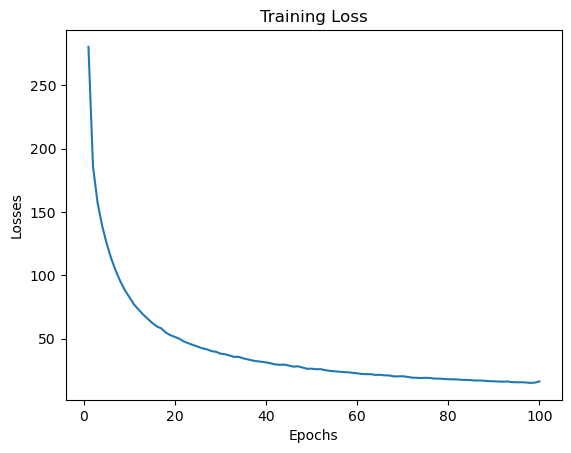

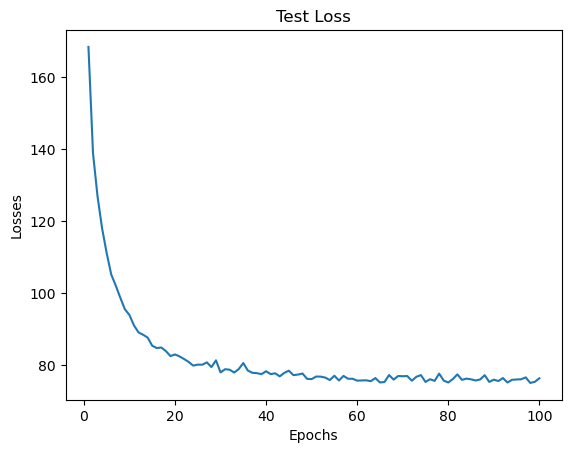

In [18]:
epochs = range(1, len(history_tl)+1)

# Plot training and test loss
plt.plot(epochs, history_tl)
plt.xlabel("Epochs")
plt.ylabel("Losses")
plt.title("Training Loss")
plt.show()

plt.plot(epochs, history_testloss)
plt.xlabel("Epochs")
plt.ylabel("Losses")
plt.title("Test Loss")
plt.show()


## Plot training and test mAP

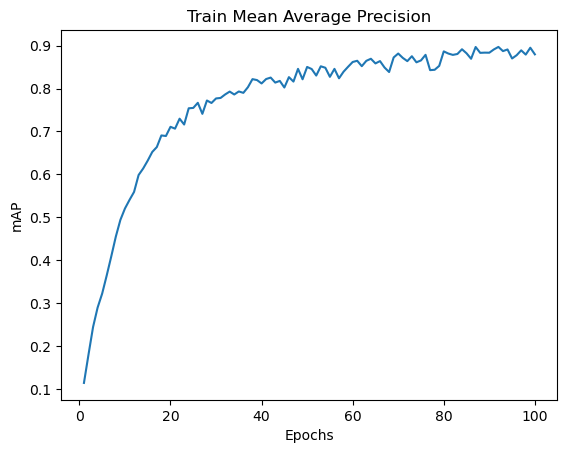

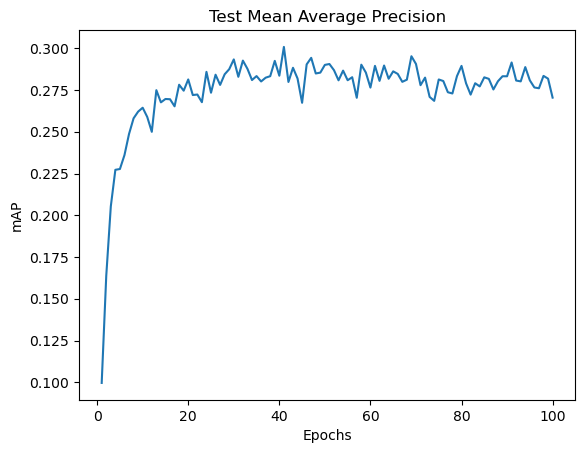

Train mAP across IOU thresholds: 0.8311
Test mAP across IOU thresholds: 0.2620


In [412]:
# Plot train and test mAP
epochs = range(1, len(history_ta)+1)

plt.plot(epochs, history_ta)
plt.xlabel("Epochs")
plt.ylabel("mAP")
plt.title("Train Mean Average Precision")
plt.show()

plt.plot(epochs, history_testmAp)
plt.xlabel("Epochs")
plt.ylabel("mAP")
plt.title("Test Mean Average Precision")
plt.show()

# Save the model
#torch.save(model.state_dict(), "ELLIPSENET_OF_sameT.pth")


 # Use the trained model to predict label
device="cuda" if torch.cuda.is_available() else "cpu" 


#load the weight that is saved uncomment to load
# model.load_state_dict(torch.load('EllipseNet.pth'))
# model.eval()

pred_boxes, target_boxes = get_bboxes(
    train_loader, model, iou_threshold=0.5, threshold=0.4
)

test_pred_boxes, test_target_boxes = get_bboxes(
    test_loader, model, iou_threshold=0.5, threshold=0.4
)

#find the mAP across all threholds takes longer and is expected to be less since across all iou thresholds
train_mAP_all_threshold = mean_average_precision(pred_boxes, target_boxes, Specific_IOU=False)
test_mAP_all_threshold  = mean_average_precision(test_pred_boxes, test_target_boxes, Specific_IOU=False)

print(f"Train mAP across IOU thresholds: {train_mAP_all_threshold:.4f}")
print(f"Test mAP across IOU thresholds: {test_mAP_all_threshold:.4f}")


## Quantitative Result

In [414]:
#create data of ten examples
ten_examples = ELLIPSEDataset(
    "Downloads/Lab4Data/10examples.csv",
    img_dir = IMG_DIR,
    label_dir = LABEL_DIR,
)

ten_examples_loader = DataLoader(
    dataset=ten_examples,
    batch_size=10,
    shuffle=False
)

model.eval()

with torch.no_grad():
    
    for inputs_test, test_label in ten_examples_loader:
        # Move data to the device
        ten_inputs_test = inputs_test.to(DEVICE)
        ten_test_label = test_label.to(DEVICE)

        # Forward pass
        ten_outputs_test = model(ten_inputs_test)
        torch.cuda.empty_cache()  # Optional: clear cache if memory is an issue

        # Calculate the test loss
        ten_loss_test = loss_fn(ten_outputs_test, ten_test_label)
    
ten_test_pred_boxes, ten_test_target_boxes = get_bboxes(
    ten_examples_loader , model, iou_threshold=0.5, threshold=0.4
    )


ten_mAP = mean_average_precision(ten_test_pred_boxes, ten_test_target_boxes, Specific_IOU=False)

print(f"mAP across the ten examples: {ten_mAP:.4f}")

mAP across the ten examples: 0.6269


## Visualization on Less Rotated

In [276]:
#plot predicted elliptical bounding boxes 
def plot_predicted_rotated_ellipse(image, boxes):
    
    im = np.array(image)
    height, width, _ = im.shape

    # Create figure and display the image
    fig, ax = plt.subplots()
    ax.imshow(im)
    
    # Create an ellipse bounding box 
    for box in boxes:
        #get the class and probability information 
        cls = int(box[0])
        prob = box[1]
        box = box[2:]
        
        assert len(box) == 5, "Got more values than in x, y, w, h, θ in a box!"
        ellipse_box = ellipse_to_polygon(box[0],box[1], box[2], box[3], box[4], num_points=100)
        
        x1, y1 = ellipse_box.exterior.xy
        x1_scaled = [xi*width for xi in x1]
        y1_scaled = [yi*height for yi in y1]
        ax.plot(x1_scaled, y1_scaled, color='r', linewidth=1)
    
        text = f"{img_labels[cls]}: {prob:.2f}"
        ax.text(
            box[0]* width,
            box[1]* height + box[3]*height/2,
            text,
            fontsize=10,
            color="r",
            verticalalignment="top",
            bbox={"facecolor": "white", "alpha": 0.7, "pad": 2},
        )

    return fig

def test_images(image_path,threshold):
    image1 = (Image.open(image_path)).resize((448,448))
    image1 = TF.to_tensor(image1).unsqueeze(0)
    image1 = image1.to(device)
    # Get bboxes by predicting bboxes for given image,  Remove multiple bboxes for same object, and plot img with bboxes
    bboxes1 = cellboxes_to_boxes(model(image1))
    bboxes1 = non_max_suppression(bboxes1[0], iou_threshold=0.5, prob_threshold=threshold)
    #plot the image with predicted ellipse
    plt.show(plot_predicted_rotated_ellipse(image1[0].permute(1,2,0).to('cpu'), bboxes1))

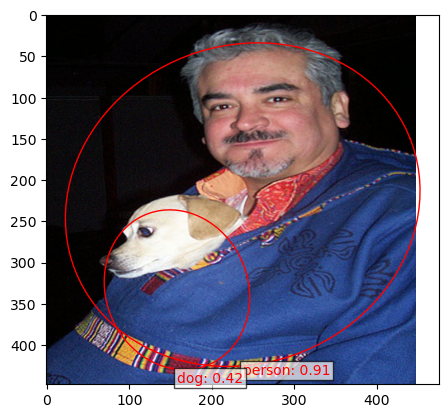

In [349]:
# Plot image with bounding box 
image_path = "Downloads/Lab4Data/images/000001.jpg"  
test_images(image_path,0.4)

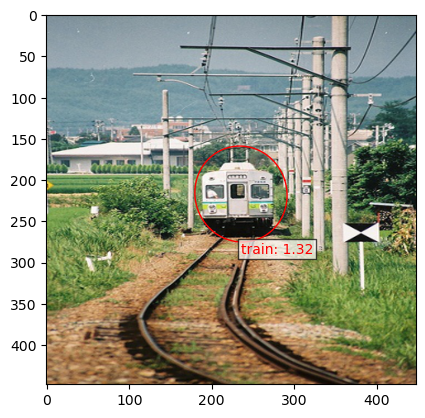

In [334]:
image_path = "Downloads/Lab4Data/images/000002.jpg"  
test_images(image_path,0.7)

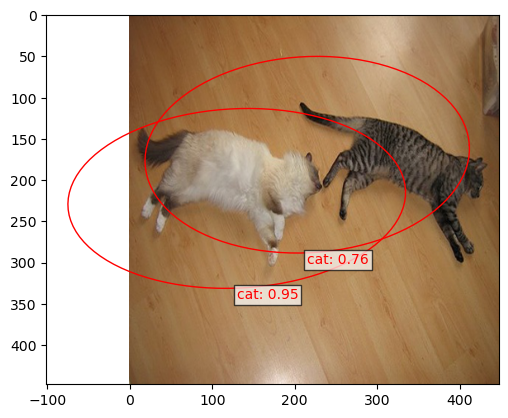

In [298]:
# Plot image with bounding box 
image_path = "Downloads/Lab4Data/images/000019.jpg"  
test_images(image_path,0.6)


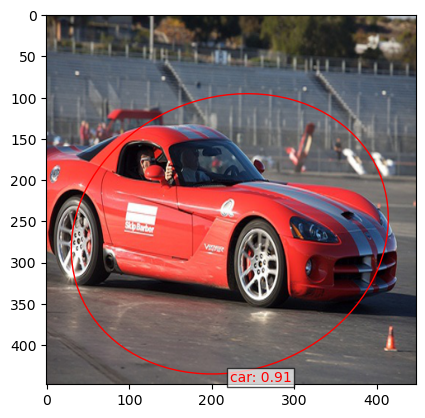

In [440]:
image_path = "Downloads/Lab4Data/images/000131.jpg"  
test_images(image_path,0.7)

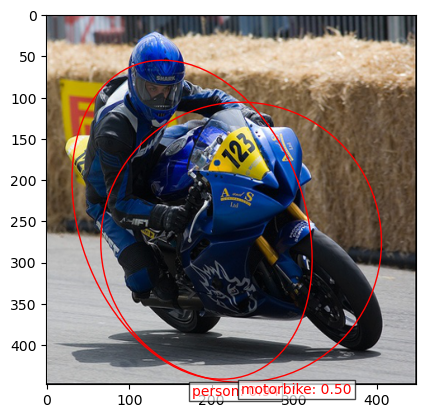

In [418]:
image_path = "Downloads/Lab4Data/images/000163.jpg"  
test_images(image_path,0.5)

## Visulazation on Rotated Images

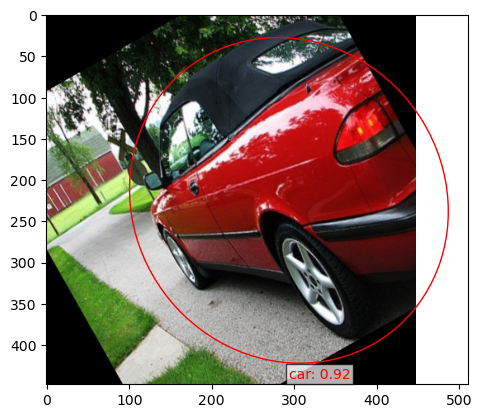

In [346]:
# Plot image with bounding box
image_path = "Downloads/Lab4Data/ellipseimages/000007.jpg"  
test_images(image_path,0.7)

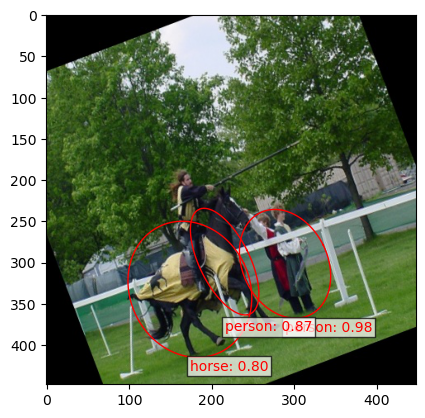

In [392]:
image_path = "Downloads/Lab4Data/ellipseimages/000009.jpg"  
test_images(image_path,0.7)

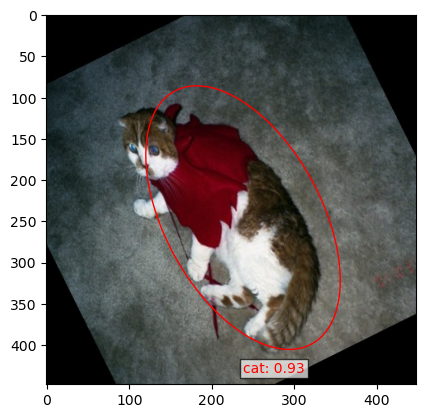

In [348]:
# Plot image with bounding box
image_path = "Downloads/Lab4Data/ellipseimages/000011.jpg"  
test_images(image_path,0.5)

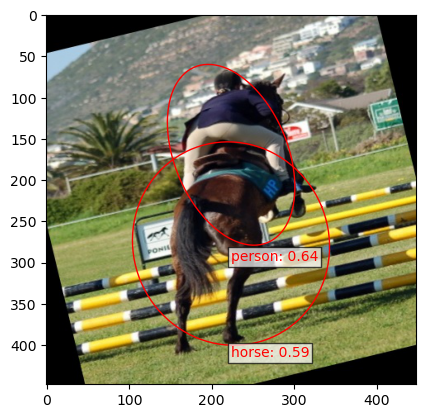

In [437]:
# Plot image with bounding box
image_path = "Downloads/Lab4Data/ellipseimages/000010.jpg"  
test_images(image_path,0.5)


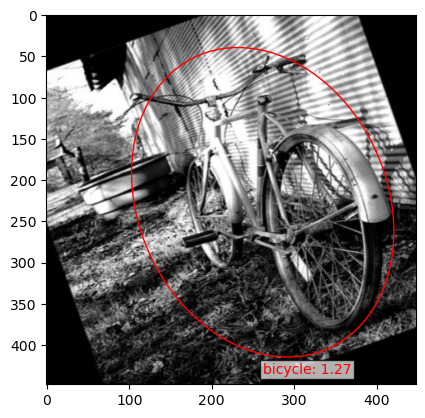

In [460]:
# Plot image with bounding box
image_path = "Downloads/Lab4Data/ellipseimages/000016.jpg"  
test_images(image_path,0.7)
